In [1]:
import torch
import torch.nn as nn
import numpy as np

In [18]:
print(np.std([11.05,11.25]))

0.09999999999999964


In [12]:
dataset = "rotmnist"
experiment_id = 80345
log_file = f"../logs/{dataset}_{experiment_id}.json"

In [13]:
# load logfile
import json
with open(log_file,'r') as f:
    logs = json.load(f)

In [14]:
# print experiment settings
from pprint import pprint
pprint(logs['args'])

{'batch_size': 32,
 'checkpoint_at': [],
 'checkpoint_dir': None,
 'data_dir': 'data_dir',
 'device': 'cuda:0',
 'enable_checkpointing': False,
 'enable_file_logging': True,
 'freeze_sigma': False,
 'h_dim': 32,
 'kl0_weight': 0.0001,
 'klp_weight': 0.0001,
 'learnable_prior': False,
 'log_dir': 'logs',
 'loglevel': 'debug',
 'lr': 0.001,
 'mc_eval_samples': 1,
 'mc_train_samples': 1,
 'n_deg': 6,
 'n_epochs': 990,
 'n_filters': 8,
 'pxz_weight': 1.0,
 'restart': 30,
 'seed': 8888,
 'z_dim': 16}


In [16]:
# print final values
from pprint import pprint
pprint(logs['final'])

{'epoch': 990,
 'trn_elbo': 0.3111298077636295,
 'trn_kl0': 55.973573218451605,
 'trn_klp': 111119.16059027778,
 'trn_log_pxz': 2672.065966796875,
 'trn_loss': 0.3111298077636295,
 'tst_elbo': 0.3363818499777052,
 'tst_kl0': 55.93969735039605,
 'tst_klp': 109755.00034722222,
 'tst_log_pxz': 4208.592730034722,
 'tst_loss': 0.3363818499777052,
 'tst_mse_full': 0.011016888585355546,
 'tst_mse_trgt': 0.011555030941963196,
 'tst_mse_trgt*': 0.011538648915787538,
 'val_elbo': 0.33558899495336747,
 'val_kl0': 55.942361195882164,
 'val_klp': 109479.52517361111,
 'val_log_pxz': 4198.674696180556,
 'val_loss': 0.33558899495336747,
 'val_mse_full': 0.010419570737414889,
 'val_mse_trgt': 0.011726842675771978,
 'val_mse_trgt*': 0.011254101163811155}


In [13]:
# plot loss curves
import matplotlib.pyplot as plt
def plot_stat(logs: dict, stat:str, modes:list = ['trn','tst', 'val']):
    fig, ax = plt.subplots(figsize=(8,3))
    for mode in modes:
        key = f"{mode}_{stat}"
        val = logs['all'][key]
        ax.plot(val, label = mode)
    ax.set_xlabel('training epochs')
    ax.set_ylabel(stat)
    ax.grid()
    return fig, ax

(<Figure size 800x300 with 1 Axes>,
 <AxesSubplot: xlabel='training epochs', ylabel='loss'>)

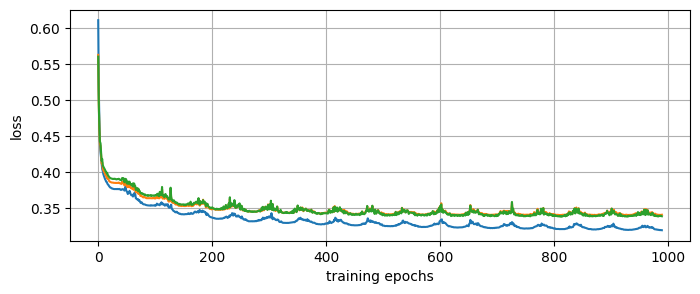

In [14]:
plot_stat(logs, 'loss')

(0.01, 0.02)

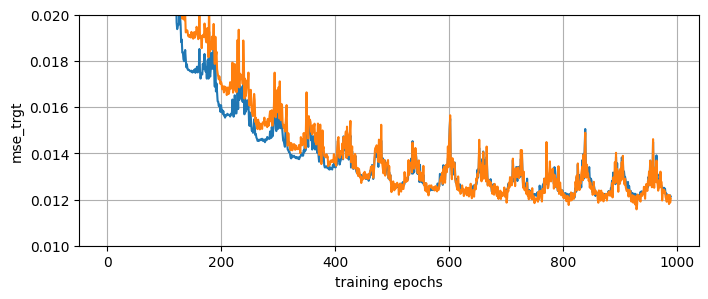

In [15]:
fig, ax = plot_stat(logs, 'mse_trgt', ['tst','val'])
ax.set_ylim((0.01,0.02))

In [113]:
# setup model
from argparse import Namespace

from core.models import RotatingMNISTRecogNetwork, RotatingMNISTReconNetwork, SOnPathDistributionEncoder, PathToBernoulliDecoder, default_SOnPathDistributionEncoder

args = Namespace(**logs['args'])
recog_net = RotatingMNISTRecogNetwork(n_filters=args.n_filters)
recon_net = RotatingMNISTReconNetwork(
    z_dim=args.z_dim, n_filters=args.n_filters * 2
)
qzx_net = default_SOnPathDistributionEncoder(
    h_dim=256, z_dim=args.z_dim, n_deg=args.n_deg, time_min=0.0, time_max=20.0
)
pxz_net = PathToBernoulliDecoder(logit_map=recon_net)

modules = nn.ModuleDict(
    {
        "recog_net": recog_net,
        "recon_net": recon_net,
        "pxz_net": pxz_net,
        "qzx_net": qzx_net,
    }
)
modules = modules.to(args.device)


In [115]:
# load_model
epoch = 921
checkpoint = f"checkpoints/checkpoint_{experiment_id}_{epoch}.h5"
checkpoint = torch.load(checkpoint)
modules.load_state_dict(checkpoint['modules'])

<All keys matched successfully>

In [116]:
from data.mnist_provider import RotatingMNISTProvider
provider = RotatingMNISTProvider(args.data_dir, random_state=133)
dl_trn = provider.get_train_loader(batch_size=args.batch_size, shuffle=True)
dl_val = provider.get_val_loader(batch_size=args.batch_size, shuffle=False)
dl_tst = provider.get_test_loader(batch_size=args.batch_size, shuffle=False)

batch = next(iter(dl_tst))

In [117]:
# generate reconstructions
dl = dl_tst
device = 'cpu'
modules = modules.to(device)
desired_t = torch.linspace(0, 0.99, provider.num_timepoints, device=device)
for _, batch in enumerate(dl):
    parts = {key: val.to(device) for key, val in batch.items()}
    inp = (parts["inp_obs"], parts["inp_msk"], parts["inp_tps"])
    h = modules["recog_net"](inp)
    qzx, pz = modules["qzx_net"](h, desired_t)
    zis = qzx.rsample((args.mc_eval_samples,))
    pxz = modules["pxz_net"](zis)
    break


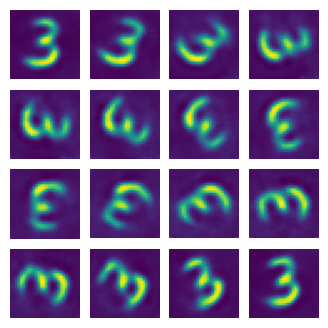

In [104]:
from mpl_toolkits.axes_grid1 import ImageGrid

rec = pxz.mean[0,0].detach().cpu()
rec = np.array(rec).transpose(0,2,3,1)

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, rec):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')

plt.show()

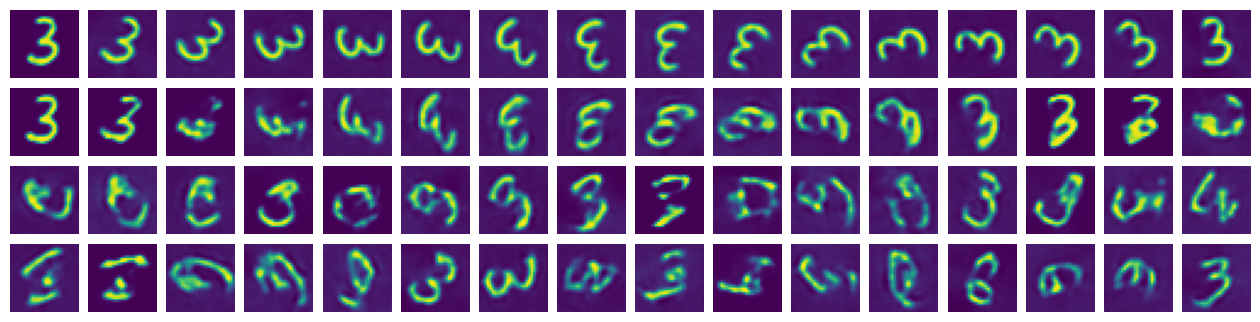

In [119]:
# extrapolate
k = 4
desired_t = torch.linspace(0, 0.99*k, k*provider.num_timepoints, device=device)

for _, batch in enumerate(dl):
    parts = {key: val.to(device) for key, val in batch.items()}
    inp = (parts["inp_obs"], parts["inp_msk"], parts["inp_tps"])
    h = modules["recog_net"](inp)
    qzx, pz = modules["qzx_net"](h, desired_t)
    zis = qzx.rsample((args.mc_eval_samples,))
    pxz = modules["pxz_net"](zis)
    break

from mpl_toolkits.axes_grid1 import ImageGrid

rec = pxz.mean[0,0].detach().cpu()
rec = np.array(rec).transpose(0,2,3,1)

fig = plt.figure(figsize=(16., 1.*k))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(k, 16),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, rec):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')

plt.show()